In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import linear_model, metrics, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
# pd.set_option('display.max_rows', 180)

In [3]:
df_prod_fin = pd.read_csv("Datos Producción Final")
df_prod_fin

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
0,23019,1,0.0,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9,6.0
1,23020,1,0.0,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2,6.6
2,23021,1,0.0,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5,8.1
3,23022,1,0.0,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8,5.9
4,23023,1,0.0,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,24049,1,0.0,14617,2024-03-16 09:22:00,2024-03-18 08:23:00,84.0,19.0,73.0,165000000.0,12912,31.0,17.0,1342.8,4.9
148,24050,1,0.0,14614,2024-03-23 08:57:00,2024-03-25 08:28:00,84.0,18.0,68.0,152000000.0,6379,29.0,27.0,1422.8,3.7
149,24051,1,0.0,13169,2024-03-23 08:57:00,2024-03-25 08:33:00,84.0,18.0,81.0,161000000.0,12912,33.0,19.0,1486.6,5.5
150,24052,2,24050.0,14614,2024-03-25 13:28:00,2024-03-27 08:51:00,86.0,17.0,69.0,148000000.0,14246,24.0,18.0,1857.3,6.0


In [4]:
df_prod_fin["Fecha/hora inicio"] = pd.to_datetime(df_prod_fin["Fecha/hora inicio"])
df_prod_fin["Fecha/hora fin"] = pd.to_datetime(df_prod_fin["Fecha/hora fin"])


In [5]:
df_original = df_prod_fin

# Generar 1000 filas adicionales mediante resampleo con reemplazo
num_filas_nuevas = 1000
df_nuevas_filas = df_original.sample(n=num_filas_nuevas, replace=True, random_state=42).reset_index(drop=True)

# Concatenar las filas originales con las nuevas
df_final = pd.concat([df_original, df_nuevas_filas], ignore_index=True)

# Mostrar la forma del DataFrame final para confirmar que tiene las nuevas filas
print(f"Filas originales: {df_original.shape[0]}")
print(f"Nuevas filas generadas: {df_nuevas_filas.shape[0]}")
print(f"Total de filas en el DataFrame final: {df_final.shape[0]}")

# Ver las primeras filas del DataFrame final
df_final.head()

Filas originales: 152
Nuevas filas generadas: 1000
Total de filas en el DataFrame final: 1152


,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
0,23019,1,0.0,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9,6.0
1,23020,1,0.0,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2,6.6
2,23021,1,0.0,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5,8.1
3,23022,1,0.0,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8,5.9
4,23023,1,0.0,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8,3.0


In [6]:
df_final

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
0,23019,1,0.0,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9,6.0
1,23020,1,0.0,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2,6.6
2,23021,1,0.0,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5,8.1
3,23022,1,0.0,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8,5.9
4,23023,1,0.0,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,24031,1,0.0,13169,2024-02-17 08:00:00,2024-02-19 07:45:00,80.0,14.8,87.2,195000000.0,14246,29.8,26.1,1812.5,6.9
1148,23116,2,23109.0,14616,2023-11-08 12:00:00,2023-11-10 09:00:00,80.0,20.2,76.6,186000000.0,17825,24.1,24.2,1673.5,7.8
1149,23035,1,0.0,14614,2023-04-25 07:45:00,2023-04-27 10:30:00,85.9,17.8,59.5,207000000.0,14246,25.2,15.1,1499.8,4.6
1150,24019,1,0.0,14617,2024-02-03 07:00:00,2024-02-05 08:15:00,80.0,16.6,75.0,182000000.0,17825,30.1,18.7,1574.7,5.7


In [7]:
df_prod_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          152 non-null    int64         
 1   Orden en el encadenado        152 non-null    int64         
 2   LOTE parental                 152 non-null    float64       
 3   ID Bioreactor                 152 non-null    int64         
 4   Fecha/hora inicio             152 non-null    datetime64[ns]
 5   Fecha/hora fin                152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  152 non-null    float64       
 7   Turbidez inicio cultivo       152 non-null    float64       
 8   Turbidez fin cultivo          152 non-null    float64       
 9   Viabilidad final cultivo      152 non-null    float64       
 10  ID Centrífuga                 152 non-null    int64         
 11  Centrifugación 1 turbidez     15

In [8]:
df_cin_fin = pd.read_csv("Datos Cineticos Cultivo Final")
df_cin_fin

,Lote,Fecha,Turbidez,Viabilidad,Glucosa g/L
0,23019,2023-03-21 07:30:00,17.28,8330000.0,1.740
1,23019,2023-03-21 11:00:00,17.28,14000000.0,1.970
2,23019,2023-03-21 14:00:00,18.40,16900000.0,1.920
3,23019,2023-03-21 18:00:00,19.76,24700000.0,1.880
4,23019,2023-03-22 07:00:00,39.12,100000000.0,1.570
...,...,...,...,...,...
1836,24110,2024-07-04 15:30:00,58.40,80500000.0,1.584
1837,24110,2024-07-04 19:30:00,69.76,102000000.0,1.248
1838,24110,2024-07-05 06:30:00,100.80,153000000.0,0.600
1839,24110,2024-07-05 08:00:00,104.80,151000000.0,0.520


In [9]:
df_cin_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841 entries, 0 to 1840
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lote         1841 non-null   int64  
 1   Fecha        1840 non-null   object 
 2   Turbidez     1831 non-null   float64
 3   Viabilidad   1839 non-null   float64
 4   Glucosa g/L  1522 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 72.0+ KB


In [10]:
# Crear las nuevas columnas para los valores iniciales y finales de glucosa
df_cin_fin['Glucosa inicial'] = df_cin_fin.groupby('Lote')['Glucosa g/L'].transform('first')
df_cin_fin['Glucosa final'] = df_cin_fin.groupby('Lote')['Glucosa g/L'].transform('last')

# Mostrar el resultado
df_cin_fin


,Lote,Fecha,Turbidez,Viabilidad,Glucosa g/L,Glucosa inicial,Glucosa final
0,23019,2023-03-21 07:30:00,17.28,8330000.0,1.740,1.740,0.210
1,23019,2023-03-21 11:00:00,17.28,14000000.0,1.970,1.740,0.210
2,23019,2023-03-21 14:00:00,18.40,16900000.0,1.920,1.740,0.210
3,23019,2023-03-21 18:00:00,19.76,24700000.0,1.880,1.740,0.210
4,23019,2023-03-22 07:00:00,39.12,100000000.0,1.570,1.740,0.210
...,...,...,...,...,...,...,...
1836,24110,2024-07-04 15:30:00,58.40,80500000.0,1.584,1.792,0.592
1837,24110,2024-07-04 19:30:00,69.76,102000000.0,1.248,1.792,0.592
1838,24110,2024-07-05 06:30:00,100.80,153000000.0,0.600,1.792,0.592
1839,24110,2024-07-05 08:00:00,104.80,151000000.0,0.520,1.792,0.592


In [11]:
df_cin_fin = df_cin_fin.drop_duplicates(subset='Lote')
df_cin_fin

,Lote,Fecha,Turbidez,Viabilidad,Glucosa g/L,Glucosa inicial,Glucosa final
0,23019,2023-03-21 07:30:00,17.28,8330000.0,1.740,1.740,0.210
10,23020,2023-03-21 07:30:00,18.80,7460000.0,1.750,1.750,0.310
20,23021,2023-03-22 07:30:00,16.16,8910000.0,1.730,1.730,0.280
31,23022,2023-03-22 07:30:00,18.48,7850000.0,1.730,1.730,0.370
42,23023,2023-03-28 08:00:00,17.12,5800000.0,1.800,1.800,0.460
...,...,...,...,...,...,...,...
1812,24104,2024-07-03 20:00:00,59.12,75700000.0,1.552,1.552,0.816
1815,24106,2024-07-01 13:15:00,23.60,10000000.0,1.944,1.944,0.560
1819,24107,2024-07-01 14:00:00,21.76,10400000.0,1.816,1.816,0.584
1823,24109,2024-07-03 16:00:00,23.84,15100000.0,1.832,1.832,0.440


In [12]:
df_prod_fin_cin_fin = pd.merge(df_prod_fin, df_cin_fin, left_on="LOTE",right_on="Lote", how="left")
df_prod_fin_cin_fin = df_prod_fin_cin_fin.drop(["Lote","Fecha","Turbidez","Viabilidad"],axis=1)
df_prod_fin_cin_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          152 non-null    int64         
 1   Orden en el encadenado        152 non-null    int64         
 2   LOTE parental                 152 non-null    float64       
 3   ID Bioreactor                 152 non-null    int64         
 4   Fecha/hora inicio             152 non-null    datetime64[ns]
 5   Fecha/hora fin                152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  152 non-null    float64       
 7   Turbidez inicio cultivo       152 non-null    float64       
 8   Turbidez fin cultivo          152 non-null    float64       
 9   Viabilidad final cultivo      152 non-null    float64       
 10  ID Centrífuga                 152 non-null    int64         
 11  Centrifugación 1 turbidez     15

In [13]:
df_prod_fin_cin_fin

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2,Glucosa g/L,Glucosa inicial,Glucosa final
0,23019,1,0.0,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9,6.0,1.740,1.740,0.210
1,23020,1,0.0,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2,6.6,1.750,1.750,0.310
2,23021,1,0.0,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5,8.1,1.730,1.730,0.280
3,23022,1,0.0,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8,5.9,1.730,1.730,0.370
4,23023,1,0.0,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8,3.0,1.800,1.800,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,24049,1,0.0,14617,2024-03-16 09:22:00,2024-03-18 08:23:00,84.0,19.0,73.0,165000000.0,12912,31.0,17.0,1342.8,4.9,1.704,1.704,0.808
148,24050,1,0.0,14614,2024-03-23 08:57:00,2024-03-25 08:28:00,84.0,18.0,68.0,152000000.0,6379,29.0,27.0,1422.8,3.7,1.880,1.880,0.928
149,24051,1,0.0,13169,2024-03-23 08:57:00,2024-03-25 08:33:00,84.0,18.0,81.0,161000000.0,12912,33.0,19.0,1486.6,5.5,1.512,1.512,0.720
150,24052,2,24050.0,14614,2024-03-25 13:28:00,2024-03-27 08:51:00,86.0,17.0,69.0,148000000.0,14246,24.0,18.0,1857.3,6.0,1.880,1.880,1.144


In [14]:
df_cin_ino = pd.read_csv("Datos Cineticos Inoculo")
df_cin_ino

,Lote,Fecha,Turbidez,Viabilidad
0,23019,2023-03-21 06:30:00,32.8,134000000.0
1,23020,2023-03-21 06:30:00,32.8,134000000.0
2,23021,2023-03-22 06:30:00,27.8,115000000.0
3,23022,2023-03-22 06:30:00,27.8,115000000.0
4,23023,2023-03-27 07:30:00,18.2,10900000.0
...,...,...,...,...
705,24111,2024-07-06 06:15:00,27.6,80400000.0
706,24111,2024-07-06 07:00:00,28.1,92800000.0
707,24108,2024-07-05 07:15:00,17.5,2170000.0
708,24108,2024-07-06 06:15:00,27.6,80400000.0


In [15]:
df_cin_ino['Turbidez inóculo inicial'] = df_cin_ino.groupby('Lote')['Turbidez'].transform('first')
df_cin_ino['Turbidez inóculo final'] = df_cin_ino.groupby('Lote')['Turbidez'].transform('last')
df_cin_ino = df_cin_ino.drop_duplicates(subset="Lote")
df_cin_ino.info()


<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 0 to 707
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Lote                      169 non-null    int64  
 1   Fecha                     169 non-null    object 
 2   Turbidez                  169 non-null    float64
 3   Viabilidad                169 non-null    float64
 4   Turbidez inóculo inicial  169 non-null    float64
 5   Turbidez inóculo final    169 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.2+ KB


In [16]:
df_prod_fin_cin_fin_cin_ino = pd.merge(df_prod_fin_cin_fin, df_cin_ino, left_on="LOTE",right_on="Lote", how='left')
df_prod_fin_cin_fin_cin_ino.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          152 non-null    int64         
 1   Orden en el encadenado        152 non-null    int64         
 2   LOTE parental                 152 non-null    float64       
 3   ID Bioreactor                 152 non-null    int64         
 4   Fecha/hora inicio             152 non-null    datetime64[ns]
 5   Fecha/hora fin                152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  152 non-null    float64       
 7   Turbidez inicio cultivo       152 non-null    float64       
 8   Turbidez fin cultivo          152 non-null    float64       
 9   Viabilidad final cultivo      152 non-null    float64       
 10  ID Centrífuga                 152 non-null    int64         
 11  Centrifugación 1 turbidez     15

In [17]:
df_prod_fin_cin_fin_cin_ino = df_prod_fin_cin_fin_cin_ino.drop(["Lote","Fecha","Viabilidad","Turbidez"],axis="columns")
df_prod_fin_cin_fin_cin_ino

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2,Glucosa g/L,Glucosa inicial,Glucosa final,Turbidez inóculo inicial,Turbidez inóculo final
0,23019,1,0.0,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9,6.0,1.740,1.740,0.210,32.8,32.8
1,23020,1,0.0,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2,6.6,1.750,1.750,0.310,32.8,32.8
2,23021,1,0.0,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5,8.1,1.730,1.730,0.280,27.8,27.8
3,23022,1,0.0,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8,5.9,1.730,1.730,0.370,27.8,27.8
4,23023,1,0.0,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8,3.0,1.800,1.800,0.460,18.2,31.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,24049,1,0.0,14617,2024-03-16 09:22:00,2024-03-18 08:23:00,84.0,19.0,73.0,165000000.0,12912,31.0,17.0,1342.8,4.9,1.704,1.704,0.808,14.8,25.3
148,24050,1,0.0,14614,2024-03-23 08:57:00,2024-03-25 08:28:00,84.0,18.0,68.0,152000000.0,6379,29.0,27.0,1422.8,3.7,1.880,1.880,0.928,14.7,25.9
149,24051,1,0.0,13169,2024-03-23 08:57:00,2024-03-25 08:33:00,84.0,18.0,81.0,161000000.0,12912,33.0,19.0,1486.6,5.5,1.512,1.512,0.720,14.7,25.9
150,24052,2,24050.0,14614,2024-03-25 13:28:00,2024-03-27 08:51:00,86.0,17.0,69.0,148000000.0,14246,24.0,18.0,1857.3,6.0,1.880,1.880,1.144,NaN,NaN


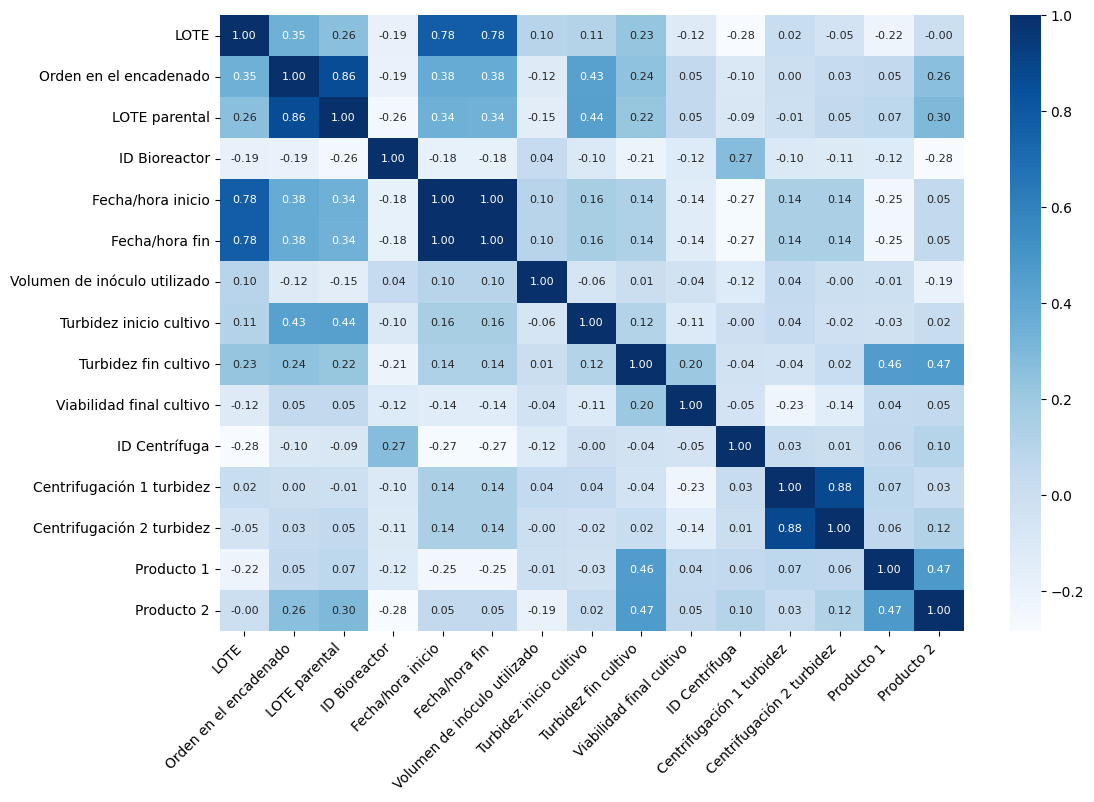

In [18]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Generar el heatmap
sns.heatmap(df_prod_fin.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", cmap="Blues")

# Rotar las etiquetas del eje X para que no se sobrepongan
plt.xticks(rotation=45, ha="right")

# Mostrar el gráfico
plt.show()

In [20]:
# df_prei_train = pd.read_csv("Datos cultivos productivos\df_prei_train.csv")
# df_prei_train = df_prei_train[["LOTE","Turbidez linea 1","Turbidez linea 2","Turbidez linea 3","PH menor 1","PH menor 2"]]
# df_prei_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LOTE              164 non-null    int64  
 1   Turbidez linea 1  162 non-null    float64
 2   Turbidez linea 2  151 non-null    float64
 3   Turbidez linea 3  134 non-null    float64
 4   PH menor 1        161 non-null    float64
 5   PH menor 2        161 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 7.8 KB


In [21]:
# df_prod_fin_cin_fin_cin_ino_prei_train = pd.merge(df_prod_fin_cin_fin_cin_ino, df_prei_train, left_on="LOTE",right_on="LOTE", how='left')
# df_prod_fin_cin_fin_cin_ino_prei_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          153 non-null    int64         
 1   Orden en el encadenado        153 non-null    int64         
 2   LOTE parental                 153 non-null    float64       
 3   ID Bioreactor                 153 non-null    int64         
 4   Fecha/hora inicio             153 non-null    datetime64[ns]
 5   Fecha/hora fin                153 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  153 non-null    float64       
 7   Turbidez inicio cultivo       153 non-null    float64       
 8   Turbidez fin cultivo          153 non-null    float64       
 9   Viabilidad final cultivo      153 non-null    float64       
 10  ID Centrífuga                 153 non-null    int64         
 11  Centrifugación 1 turbidez     15

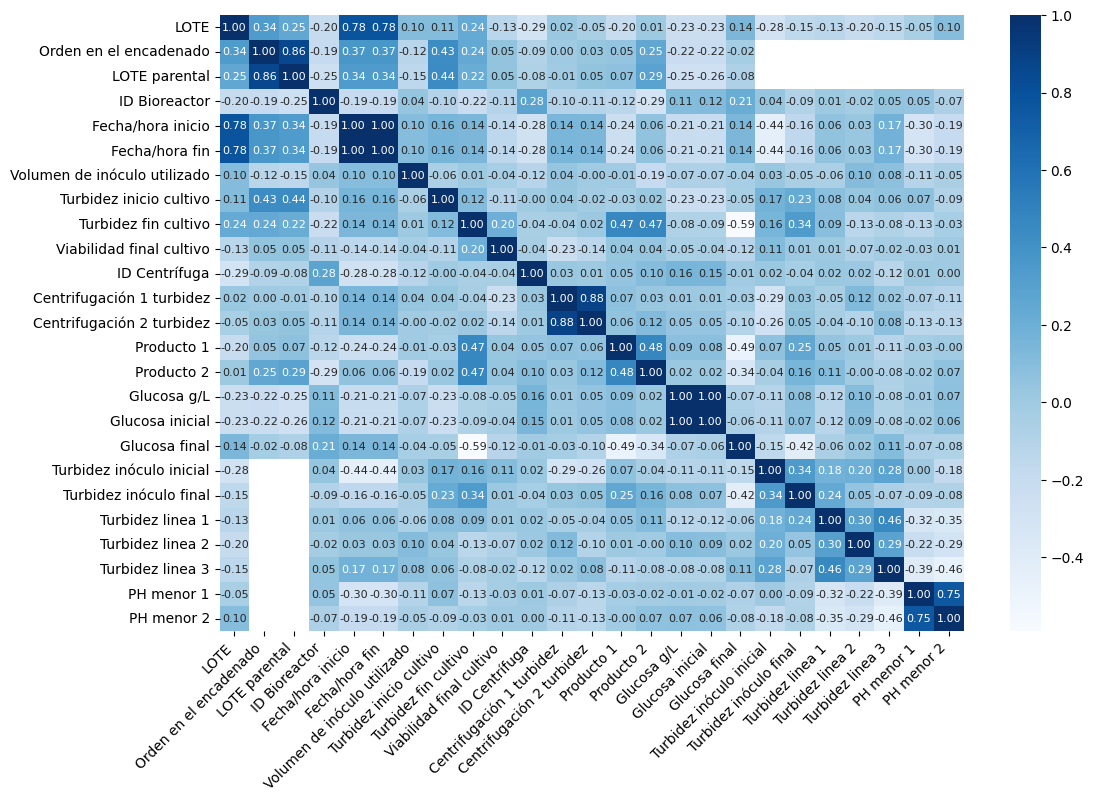

In [22]:
# # Ajustar el tamaño de la figura
# plt.figure(figsize=(12, 8))

# # Generar el heatmap
# sns.heatmap(df_prod_fin_cin_fin_cin_ino_prei_train.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", cmap="Blues")

# # Rotar las etiquetas del eje X para que no se sobrepongan
# plt.xticks(rotation=45, ha="right")

# # Mostrar el gráfico
# plt.show()

In [23]:
df_prod_fin_cin_fin_cin_ino_prei_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          153 non-null    int64         
 1   Orden en el encadenado        153 non-null    int64         
 2   LOTE parental                 153 non-null    float64       
 3   ID Bioreactor                 153 non-null    int64         
 4   Fecha/hora inicio             153 non-null    datetime64[ns]
 5   Fecha/hora fin                153 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  153 non-null    float64       
 7   Turbidez inicio cultivo       153 non-null    float64       
 8   Turbidez fin cultivo          153 non-null    float64       
 9   Viabilidad final cultivo      153 non-null    float64       
 10  ID Centrífuga                 153 non-null    int64         
 11  Centrifugación 1 turbidez     15

In [20]:
df_temp = pd.read_csv("resultado_inicios_y_finales_con_todo_train.csv")
df_temp = df_temp.drop(["Fecha/hora inicio","Fecha/hora fin"],axis="columns")
df_temp["LOTE"] = df_prod_fin_cin_fin_cin_ino["LOTE"]
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Temperatura almacén principal (inicio)   152 non-null    float64
 1   Humedad almacén principal (inicio)       152 non-null    float64
 2   Temperatura almacén producción (inicio)  152 non-null    float64
 3   Humedad almacén producción (inicio)      152 non-null    float64
 4   Temperatura almacén principal (fin)      152 non-null    float64
 5   Humedad almacén principal (fin)          152 non-null    float64
 6   Temperatura almacén producción (fin)     152 non-null    float64
 7   Humedad almacén producción (fin)         152 non-null    float64
 8   Temperatura biorreactores (inicio)       152 non-null    float64
 9   Humedad biorreactores (inicio)           152 non-null    float64
 10  Temperatura biorreactores (fin)          152 non-n

In [21]:
df_prod_fin_cin_fin_cin_ino_prei_train_temp = pd.merge(df_prod_fin_cin_fin_cin_ino,df_temp, left_on="LOTE", right_on="LOTE",how="right")
df_prod_fin_cin_fin_cin_ino_prei_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   LOTE                                     152 non-null    int64         
 1   Orden en el encadenado                   152 non-null    int64         
 2   LOTE parental                            152 non-null    float64       
 3   ID Bioreactor                            152 non-null    int64         
 4   Fecha/hora inicio                        152 non-null    datetime64[ns]
 5   Fecha/hora fin                           152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado             152 non-null    float64       
 7   Turbidez inicio cultivo                  152 non-null    float64       
 8   Turbidez fin cultivo                     152 non-null    float64       
 9   Viabilidad final cultivo                 15

In [22]:
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Orden en el encadenado"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Orden en el encadenado"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["LOTE parental"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["LOTE parental"].fillna(0)

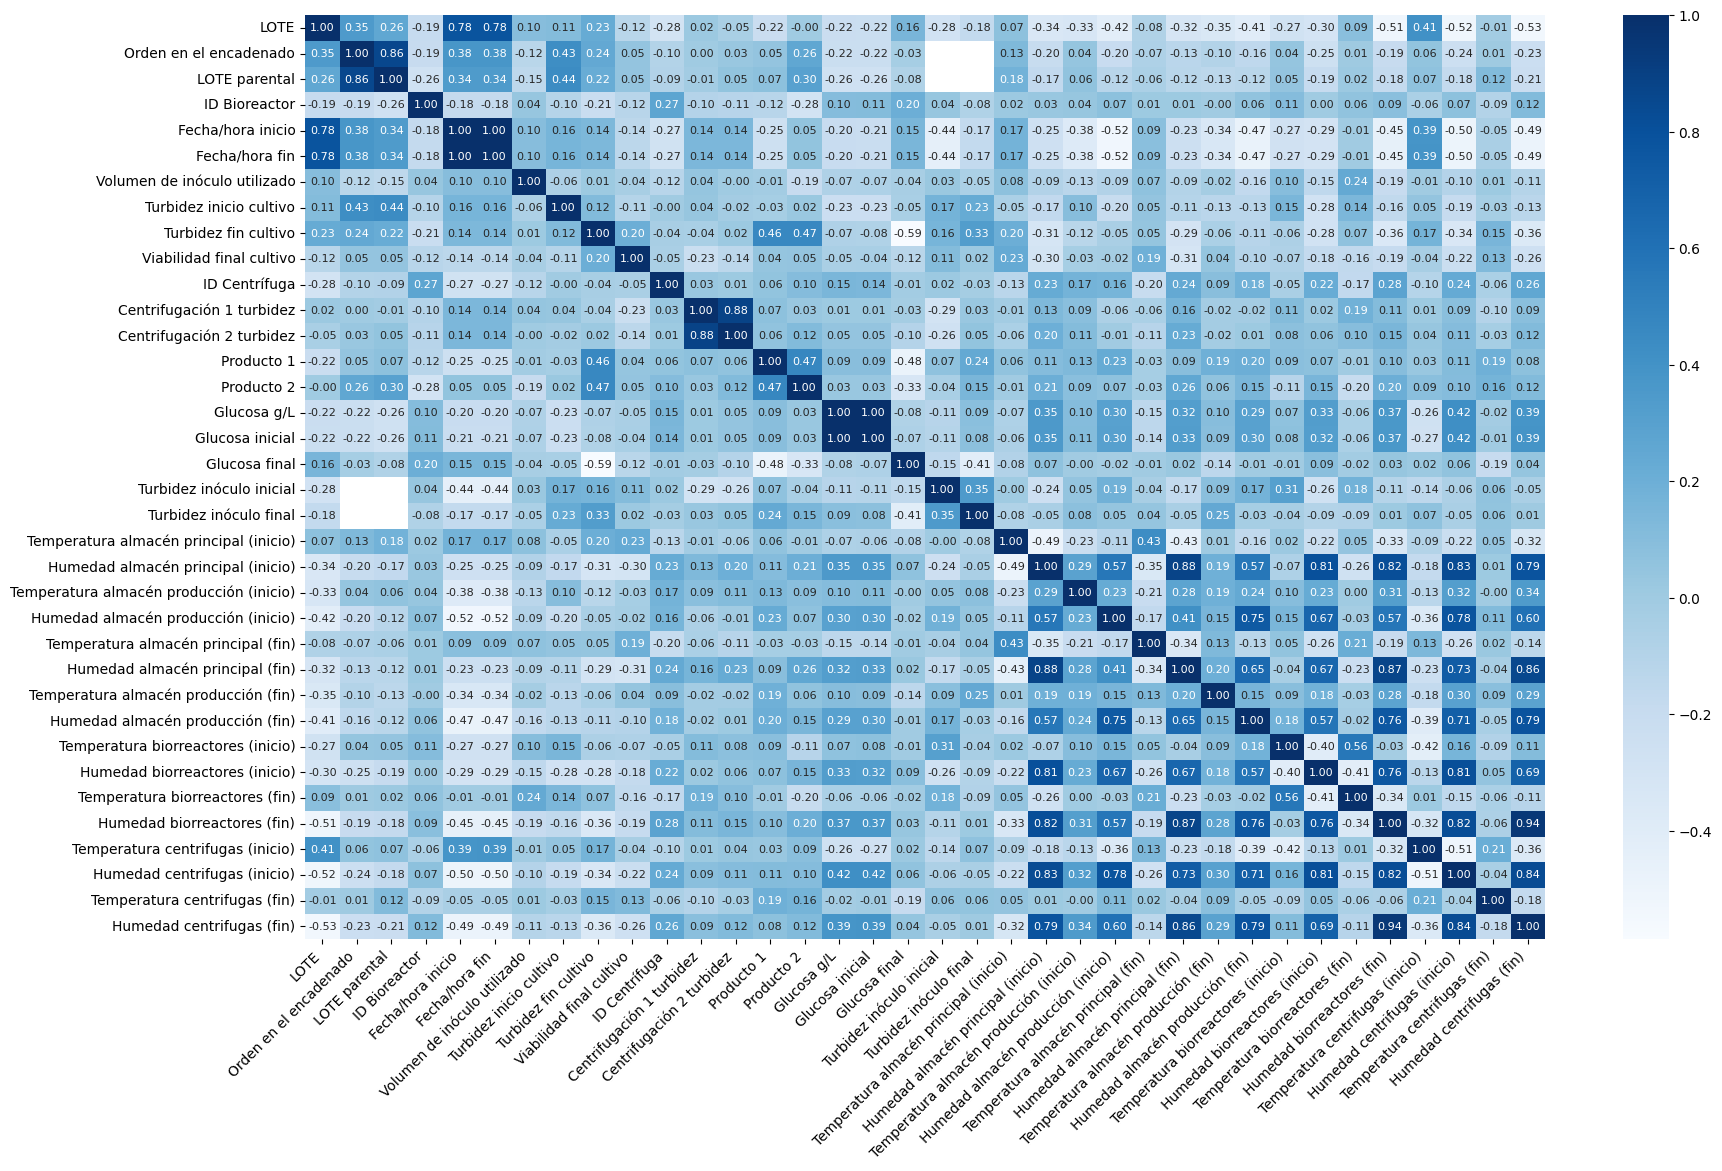

In [23]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(20, 12))

# Generar el heatmap
sns.heatmap(df_prod_fin_cin_fin_cin_ino_prei_train_temp.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", cmap="Blues")

# Rotar las etiquetas del eje X para que no se sobrepongan
plt.xticks(rotation=45, ha="right")

# Mostrar el gráfico
plt.show()

In [25]:
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa g/L"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa g/L"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa inicial"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa inicial"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa final"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Glucosa final"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez inóculo inicial"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez inóculo inicial"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez inóculo final"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez inóculo final"].fillna(0)
# df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 1"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 1"].fillna(0)
# df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 2"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 2"].fillna(0)
# df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 3"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Turbidez linea 3"].fillna(0)
# df_prod_fin_cin_fin_cin_ino_prei_train_temp["PH menor 1"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["PH menor 1"].fillna(0)
# df_prod_fin_cin_fin_cin_ino_prei_train_temp["PH menor 2"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["PH menor 2"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén principal (inicio)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén principal (inicio)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén principal (inicio)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén principal (inicio)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén producción (inicio)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén producción (inicio)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén principal (fin)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén principal (fin)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén principal (fin)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén principal (fin)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén producción (fin)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Temperatura almacén producción (fin)"].fillna(0)
df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén producción (fin)"] = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Humedad almacén producción (fin)"].fillna(0)



In [26]:
df_prod_fin_cin_fin_cin_ino_prei_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   LOTE                                     152 non-null    int64         
 1   Orden en el encadenado                   152 non-null    int64         
 2   LOTE parental                            152 non-null    float64       
 3   ID Bioreactor                            152 non-null    int64         
 4   Fecha/hora inicio                        152 non-null    datetime64[ns]
 5   Fecha/hora fin                           152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado             152 non-null    float64       
 7   Turbidez inicio cultivo                  152 non-null    float64       
 8   Turbidez fin cultivo                     152 non-null    float64       
 9   Viabilidad final cultivo                 15

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import linear_model, metrics, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [48]:
X = df_prod_fin_cin_fin_cin_ino_prei_train_temp.drop(['LOTE','Glucosa g/L','Producto 2', 'Fecha/hora inicio','Fecha/hora fin'],axis='columns')
X

,Orden en el encadenado,LOTE parental,ID Bioreactor,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,...,Temperatura almacén producción (fin),Humedad almacén producción (fin),Temperatura biorreactores (inicio),Humedad biorreactores (inicio),Temperatura biorreactores (fin),Humedad biorreactores (fin),Temperatura centrifugas (inicio),Humedad centrifugas (inicio),Temperatura centrifugas (fin),Humedad centrifugas (fin)
0,1,0.0,14615,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,...,20.203993,52.759693,20.769315,42.575630,20.519910,49.922036,19.750283,43.381756,20.761100,49.984621
1,1,0.0,14616,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,...,20.203993,52.759693,20.769315,42.575630,20.519910,49.922036,19.750283,43.381756,20.761100,49.984621
2,1,0.0,13170,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,...,20.251013,49.515335,22.340484,40.619897,18.877224,42.477821,18.655607,46.747024,19.002116,40.868383
3,1,0.0,14614,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,...,20.251013,49.515335,22.340484,40.619897,18.877224,42.477821,18.655607,46.747024,19.002116,40.868383
4,1,0.0,14615,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,...,19.797092,47.630932,20.951063,41.009770,18.944965,47.147298,18.460646,44.969654,18.655964,47.595199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,1,0.0,14617,84.0,19.0,73.0,165000000.0,12912,31.0,17.0,...,20.355974,52.343750,19.042997,56.716159,20.334065,54.099913,19.759992,52.699882,21.233287,49.815365
148,1,0.0,14614,84.0,18.0,68.0,152000000.0,6379,29.0,27.0,...,20.223957,51.674622,22.336437,50.637980,21.649652,47.952069,20.245257,54.090889,21.129045,46.822657
149,1,0.0,13169,84.0,18.0,81.0,161000000.0,12912,33.0,19.0,...,20.223957,51.808449,22.336437,50.637980,20.568031,51.620970,20.245257,54.090889,18.548282,54.244526
150,2,24050.0,14614,86.0,17.0,69.0,148000000.0,14246,24.0,18.0,...,19.746527,44.696950,19.265977,59.204502,18.946753,37.797011,19.923050,55.781724,18.336776,36.823635


In [49]:
y = df_prod_fin_cin_fin_cin_ino_prei_train_temp["Producto 1"]
y

0      1747.9
1      1676.2
2      1928.5
3      1782.8
4      1861.8
        ...  
147    1342.8
148    1422.8
149    1486.6
150    1857.3
151    1784.1
Name: Producto 1, Length: 152, dtype: float64

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2, random_state = 42)

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que ya tienes tus datos en X e y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos y los hiperparámetros a ajustar
models = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(),
    'Random Forest': RandomForestRegressor()
}

# Hiperparámetros para cada modelo
param_grid = {
    'Linear Regression': {},
    'Elastic Net': {
        'alpha': np.logspace(-3, 2, 5),  # Aumenta la regularización
        'l1_ratio': np.linspace(0.1, 0.9, 3)  # Mezcla de penalización L1 y L2
    },
    'Random Forest': {
        'n_estimators': [25],  # Menos árboles
        'max_depth': [2],  # Limitar la profundidad del árbol para simplicidad
        'min_samples_split': [2,4],  # Evitar divisiones pequeñas
        'min_samples_leaf': [2,4]  # Evitar hojas con muy pocos datos
    }}

# Realizar el Grid Search para cada modelo
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=20, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f"{name} Best Parameters: {grid_search.best_params_}")
    print(f"{name} Best CV MSE: {-grid_search.best_score_}")

# Evaluar los modelos en el conjunto de prueba
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # Calcular R²
    print(f"{name} Test MSE: {mse}, R²: {r2}")

Linear Regression Best Parameters: {}
Linear Regression Best CV MSE: 8.526576831003961e-22
Elastic Net Best Parameters: {'alpha': np.float64(0.01778279410038923), 'l1_ratio': np.float64(0.9)}
Elastic Net Best CV MSE: 1.374002765149553e-07
Random Forest Best Parameters: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}
Random Forest Best CV MSE: 8118.436627119258
Linear Regression Test MSE: 1.9034368146954224e-22, R²: 1.0
Elastic Net Test MSE: 1.9555182137997516e-07, R²: 0.9999999999970798
Random Forest Test MSE: 1433.448469760145, R²: 0.978593936377945


In [47]:
X

,Orden en el encadenado,LOTE parental,ID Bioreactor,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,...,Temperatura almacén producción (fin),Humedad almacén producción (fin),Temperatura biorreactores (inicio),Humedad biorreactores (inicio),Temperatura biorreactores (fin),Humedad biorreactores (fin),Temperatura centrifugas (inicio),Humedad centrifugas (inicio),Temperatura centrifugas (fin),Humedad centrifugas (fin)
0,1,0.0,14615,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,...,20.203993,52.759693,20.769315,42.575630,20.519910,49.922036,19.750283,43.381756,20.761100,49.984621
1,1,0.0,14616,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,...,20.203993,52.759693,20.769315,42.575630,20.519910,49.922036,19.750283,43.381756,20.761100,49.984621
2,1,0.0,13170,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,...,20.251013,49.515335,22.340484,40.619897,18.877224,42.477821,18.655607,46.747024,19.002116,40.868383
3,1,0.0,14614,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,...,20.251013,49.515335,22.340484,40.619897,18.877224,42.477821,18.655607,46.747024,19.002116,40.868383
4,1,0.0,14615,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,...,19.797092,47.630932,20.951063,41.009770,18.944965,47.147298,18.460646,44.969654,18.655964,47.595199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,1,0.0,14617,84.0,19.0,73.0,165000000.0,12912,31.0,17.0,...,20.355974,52.343750,19.042997,56.716159,20.334065,54.099913,19.759992,52.699882,21.233287,49.815365
148,1,0.0,14614,84.0,18.0,68.0,152000000.0,6379,29.0,27.0,...,20.223957,51.674622,22.336437,50.637980,21.649652,47.952069,20.245257,54.090889,21.129045,46.822657
149,1,0.0,13169,84.0,18.0,81.0,161000000.0,12912,33.0,19.0,...,20.223957,51.808449,22.336437,50.637980,20.568031,51.620970,20.245257,54.090889,18.548282,54.244526
150,2,24050.0,14614,86.0,17.0,69.0,148000000.0,14246,24.0,18.0,...,19.746527,44.696950,19.265977,59.204502,18.946753,37.797011,19.923050,55.781724,18.336776,36.823635


In [52]:
# rf = RandomForestRegressor(n_jobs=-1)
xgb = XGBRegressor(max_depth=1)
xgb.fit(X_train,y_train)
# rf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
predictions = xgb.predict(X_test)
predictions

array([1336.115 , 1356.744 , 1960.9207, 1819.6407, 1538.9663, 1239.914 ,
       2083.3906, 1816.0431, 1681.9987, 1529.0475, 1840.8651, 1511.6115,
       1966.1588, 1491.3903,  972.8022, 1371.3247, 1473.4248, 1727.461 ,
       1837.3201, 1358.8032, 1352.4852, 1275.7964, 1831.5815, 1828.0725,
       1516.7584, 1145.9109, 1828.5546, 1693.2906, 1459.5283, 1818.6433,
       1861.6815], dtype=float32)

In [54]:
xgb.score(X_test,y_test)

0.9846771745939115

In [40]:
x = 0
for n in range(1,15):
    xgb = XGBRegressor(max_depth=n)
    xgb.fit(X_train,y_train)
    y = xgb.score(X_test,y_test)
    if y > x:
        x = y
    print(n,x)

1 0.9841872198958251
2 0.9880250189063353
3 0.993655657670563
4 0.9937587203608501
5 0.9947732593843533
6 0.9953578617053567
7 0.9958150749751059
8 0.9958538857042298
9 0.9959334982163154
10 0.995935510109221
11 0.995935510109221
12 0.995936908620026
13 0.995936908620026
14 0.995936908620026


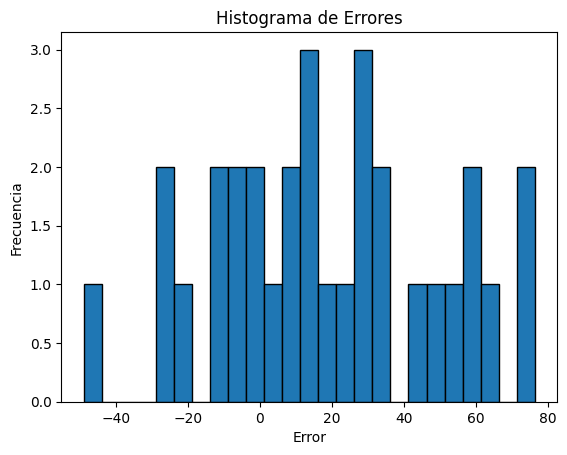

In [89]:
errors = y_test - predictions

plt.hist(errors, bins=25, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores')
plt.show()


# MODELADO

In [150]:
df_prod_fin = df_prod_fin.drop(["Fecha/hora inicio","Fecha/hora fin","Producto 2"],axis="columns")
df_prod_fin.fillna(0)
df_prod_fin

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1
0,23019,1,0.0,14615,82.4,17.3,91.2,184000000.0,17825,0.0,0.0,1747.9
1,23020,1,0.0,14616,80.4,18.8,91.2,182000000.0,14246,0.0,0.0,1676.2
2,23021,1,0.0,13170,66.4,16.2,86.4,248000000.0,17825,0.0,0.0,1928.5
3,23022,1,0.0,14614,85.6,18.5,83.2,230000000.0,12912,0.0,0.0,1782.8
4,23023,1,0.0,14615,77.6,17.1,74.4,133000000.0,17825,26.6,20.9,1861.8
5,23024,1,0.0,14616,76.0,16.6,80.8,199000000.0,14246,24.6,10.4,2161.1
6,23025,1,0.0,13170,77.2,17.8,87.2,199000000.0,17825,30.6,29.4,2044.7
7,23026,1,0.0,14614,78.8,18.2,81.2,206000000.0,14246,26.5,11.6,2263.2
8,23027,1,0.0,14615,83.2,16.9,68.1,195000000.0,14246,26.2,9.8,1407.7
9,23028,1,0.0,14616,83.6,18.6,67.2,176000000.0,17825,27.3,12.2,1373.2


In [146]:
X = df_prod_fin.drop(["Producto 1"],axis='columns')
y = df_prod_fin["Producto 1"]    

In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que ya tienes tus datos en X e y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos y los hiperparámetros a ajustar
models = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(),
    'Random Forest': RandomForestRegressor()
}

# Hiperparámetros para cada modelo
param_grid = {
    'Linear Regression': {},
    'Elastic Net': {'alpha': np.logspace(-3, 3, 7), 'l1_ratio': np.linspace(0, 1, 5)},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3], 'min_samples_split': [2, 5]}
}

# Realizar el Grid Search para cada modelo
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f"{name} Best Parameters: {grid_search.best_params_}")
    print(f"{name} Best CV MSE: {-grid_search.best_score_}")

# Evaluar los modelos en el conjunto de prueba
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # Calcular R²
    print(f"{name} Test MSE: {mse}, R²: {r2}")

Linear Regression Best Parameters: {}
Linear Regression Best CV MSE: 97517.49027316875
Elastic Net Best Parameters: {'alpha': np.float64(100.0), 'l1_ratio': np.float64(1.0)}
Elastic Net Best CV MSE: 90071.51307838634
Random Forest Best Parameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Best CV MSE: 93275.40458971998
Linear Regression Test MSE: 50530.76346494065, R²: 0.245410797513688
Elastic Net Test MSE: 50146.657329768575, R²: 0.2511467556179168
Random Forest Test MSE: 46467.735307621384, R²: 0.3060850673382113


In [193]:
df_prod_fin_cin_fin_cin_ino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          152 non-null    int64         
 1   Orden en el encadenado        152 non-null    int64         
 2   LOTE parental                 152 non-null    float64       
 3   ID Bioreactor                 152 non-null    int64         
 4   Fecha/hora inicio             152 non-null    datetime64[ns]
 5   Fecha/hora fin                152 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  152 non-null    float64       
 7   Turbidez inicio cultivo       152 non-null    float64       
 8   Turbidez fin cultivo          152 non-null    float64       
 9   Viabilidad final cultivo      152 non-null    float64       
 10  ID Centrífuga                 152 non-null    int64         
 11  Centrifugación 1 turbidez     15

In [194]:
df_prod_fin_cin_fin_cin_ino = df_prod_fin_cin_fin_cin_ino.drop(["LOTE","Orden en el encadenado","LOTE parental","ID Bioreactor","Fecha/hora inicio","Fecha/hora fin","Producto 2"],axis="columns")
df_prod_fin_cin_fin_cin_ino = df_prod_fin_cin_fin_cin_ino.fillna(0)

In [178]:
df_prod_fin_cin_fin_cin_ino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Orden en el encadenado        152 non-null    int64  
 1   LOTE parental                 152 non-null    float64
 2   ID Bioreactor                 152 non-null    int64  
 3   Volumen de inóculo utilizado  152 non-null    float64
 4   Turbidez inicio cultivo       152 non-null    float64
 5   Turbidez fin cultivo          152 non-null    float64
 6   Viabilidad final cultivo      152 non-null    float64
 7   ID Centrífuga                 152 non-null    int64  
 8   Centrifugación 1 turbidez     152 non-null    float64
 9   Centrifugación 2 turbidez     152 non-null    float64
 10  Producto 1                    152 non-null    float64
 11  Glucosa g/L                   152 non-null    float64
 12  Glucosa inicial               152 non-null    float64
 13  Gluco

In [175]:
df_prod_fin_cin_fin_cin_ino = df_prod_fin_cin_fin_cin_ino.fillna(0)

In [179]:
df_prod_fin_cin_fin_cin_ino = df_prod_fin_cin_fin_cin_ino.drop("Glucosa final",axis="columns")

In [195]:
X = df_prod_fin_cin_fin_cin_ino.drop(["Producto 1"],axis='columns')
y = df_prod_fin_cin_fin_cin_ino["Producto 1"] 


In [196]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# # Suponiendo que ya tienes tus datos en X e y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Definir los modelos y los hiperparámetros a ajustar
# models = {
#     'Linear Regression': LinearRegression(),
#     'Elastic Net': ElasticNet(),
#     'Random Forest': RandomForestRegressor()
# }

# # Hiperparámetros para cada modelo
# param_grid = {
#     'Linear Regression': {},
#     'Elastic Net': {'alpha': np.logspace(-3, 3, 7), 'l1_ratio': np.linspace(0, 1, 5)},
#     'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3], 'min_samples_split': [2, 5]}
# }

# # Realizar el Grid Search para cada modelo
# best_models = {}
# for name, model in models.items():
#     grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     best_models[name] = grid_search.best_estimator_
#     print(f"{name} Best Parameters: {grid_search.best_params_}")
#     print(f"{name} Best CV MSE: {-grid_search.best_score_}")

# # Evaluar los modelos en el conjunto de prueba
# for name, model in best_models.items():
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)  # Calcular R²
#     print(f"{name} Test MSE: {mse}, R²: {r2}")

Linear Regression Best Parameters: {}
Linear Regression Best CV MSE: 96612.69400459745
Elastic Net Best Parameters: {'alpha': np.float64(100.0), 'l1_ratio': np.float64(1.0)}
Elastic Net Best CV MSE: 86190.59032109252
Random Forest Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best CV MSE: 93000.13271337748
Linear Regression Test MSE: 50968.68768411466, R²: 0.23887115978339257
Elastic Net Test MSE: 49616.12452212147, R²: 0.2590693417963942
Random Forest Test MSE: 40922.07972860892, R²: 0.3888998030295533


In [152]:
xgb = XGBRegressor(max_depth=1)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [153]:
predictions = xgb.predict(X_test)
predictions

array([1479.2595, 1608.7843, 1838.401 , 1754.4822, 1814.1547, 1729.7684,
       1630.9613, 1907.728 , 1569.9039, 1574.6974, 1806.0073, 1582.577 ,
       1763.9542, 1538.8523, 1309.4639, 1581.5765, 1614.743 , 1693.702 ,
       1869.9037, 1795.074 , 1564.9794, 1304.0109, 1512.6903, 1624.871 ,
       1513.5901, 1381.8954, 1774.5992, 1783.4824, 1674.1477, 1367.268 ,
       1701.3259], dtype=float32)

In [154]:
# METRICAS DE TEST, LAS BUENAS, HACEOS LA PREGUNTA: QUE TAL LO ESTAMOS HACIENDO?
print('MAE test', mean_absolute_error(y_test, predictions))
print('MAPE test', mean_absolute_percentage_error(y_test, predictions))
print('MSE test', mean_squared_error(y_test, predictions))# si esto
print('RMSE test', np.sqrt(mean_squared_error(y_test, predictions)))# y esto se parece, fallo mucho, por poco, si no se parecen, fallo mucho, pocas veces
print('R2 score test', r2_score(y_test, predictions))# porcentual de aciertos

MAE test 170.06926663306453
MAPE test 0.11307932532984435
MSE test 46691.83915194142
RMSE test 216.0829450742039
R2 score test 0.30273846559377293


In [155]:
x = 0
for n in range(1,10):
    xgb = XGBRegressor(max_depth=n)
    xgb.fit(X_train,y_train)
    predictions = xgb.predict(X_test)
    y = r2_score(y_test, predictions)
    print(n,y)

1 0.30273846559377293
2 0.25716829506951167
3 0.3459196434950541
4 0.4063998002086705
5 0.30115201858419105
6 0.1307022424428499
7 0.2686772381656418
8 0.3129483553509551
9 0.229872514493357


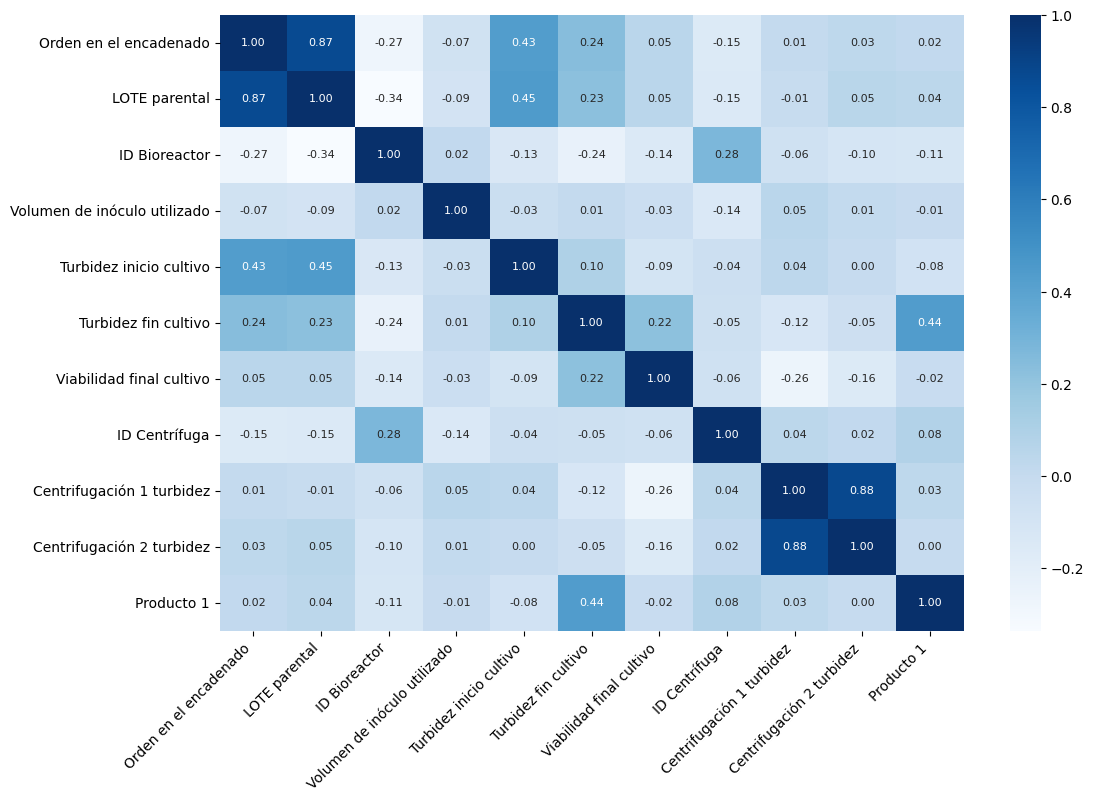

In [124]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Generar el heatmap
sns.heatmap(df_final.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", cmap="Blues")

# Rotar las etiquetas del eje X para que no se sobrepongan
plt.xticks(rotation=45, ha="right")

# Mostrar el gráfico
plt.show()